In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error

In [65]:
df = pd.read_csv("./data/PRSA_Data_Aotizhongxin_20130301-20170228.csv")
df["ts"] = pd.to_datetime(df[["year", "month", "day", "hour"]])
print(df.shape)
df.head()

(35064, 19)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station,ts
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin,2013-03-01 04:00:00


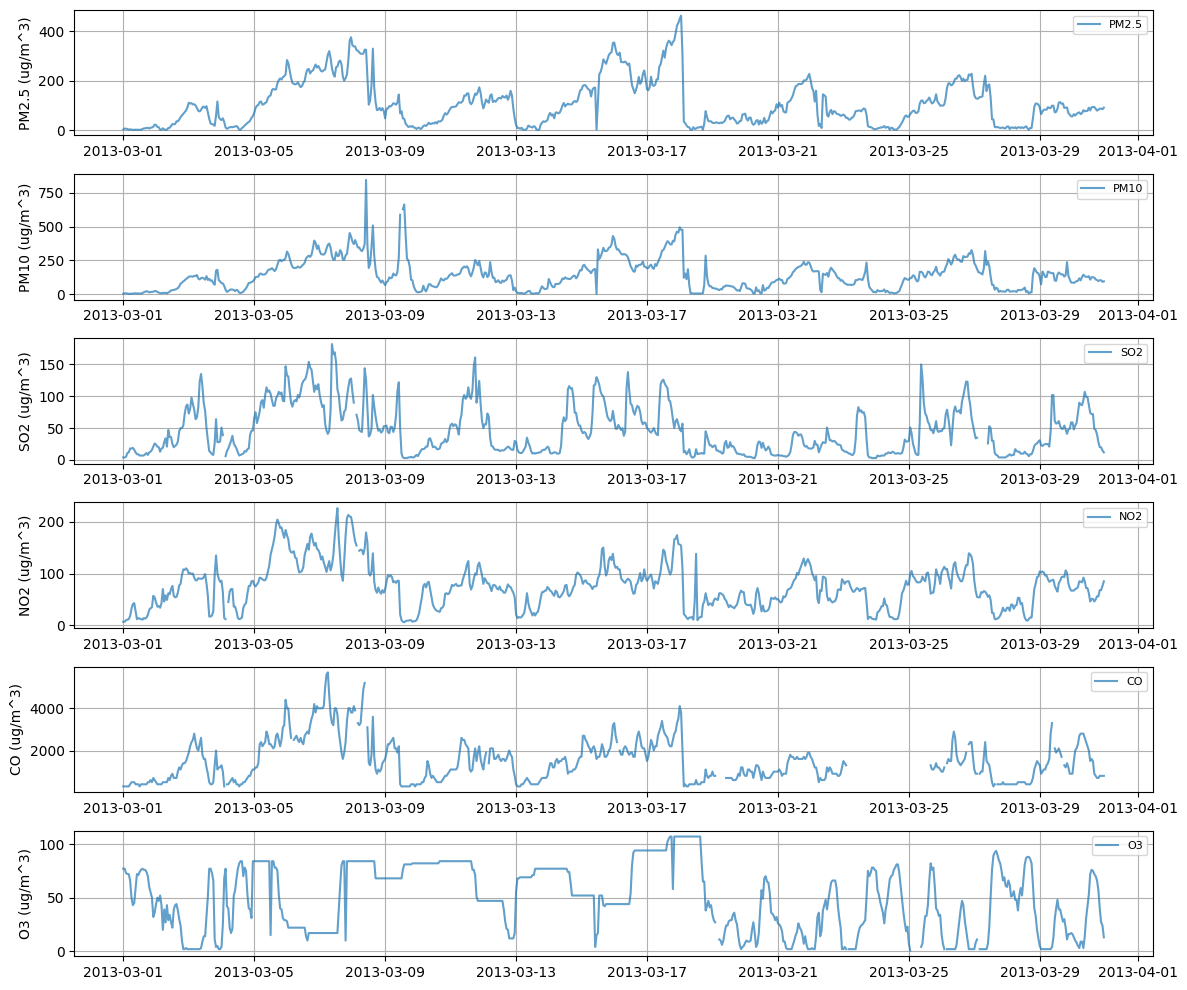

In [66]:
df_firstmonth = df.iloc[:720]   # first 30 days * 24 hours

fig, axs = plt.subplots(6, 1, figsize=(12, 10))

pollutants = ["PM2.5", "PM10", "SO2", "NO2", "CO", "O3"]
for i in range(len(pollutants)):
    axs[i].plot(df_firstmonth['ts'], df_firstmonth[pollutants[i]], label=pollutants[i], alpha=0.7)
    axs[i].set_ylabel(pollutants[i]+ " (ug/m^3)")
    axs[i].legend(ncol=4, fontsize=8)
    axs[i].grid(True)

plt.tight_layout()
plt.show()


In [67]:

def wd_to_deg(wd_series):
    """Convert wind direction (categorical) to degrees (numeric)"""
    mapping = {
        "N": 0, "NNE": 22.5, "NE": 45, "ENE": 67.5,
        "E": 90, "ESE": 112.5, "SE": 135, "SSE": 157.5,
        "S": 180, "SSW": 202.5, "SW": 225, "WSW": 247.5,
        "W": 270, "WNW": 292.5, "NW": 315, "NNW": 337.5
    }
    return wd_series.map(mapping)

def add_features(df, ts_col="ts"):
    out = df.copy()
    out["hour"] = out[ts_col].dt.hour
    out["dow"]  = out[ts_col].dt.dayofweek
    out["month"]= out[ts_col].dt.month
    # cyclic encodings (help linear models)
    out["sin_h"] = np.sin(2*np.pi*out["hour"]/24)
    out["cos_h"] = np.cos(2*np.pi*out["hour"]/24)
    out["sin_d"] = np.sin(2*np.pi*out["dow"]/7)
    out["cos_d"] = np.cos(2*np.pi*out["dow"]/7)
    out["sin_m"] = np.sin(2*np.pi*out["month"]/12)
    out["cos_m"] = np.cos(2*np.pi*out["month"]/12)
    out["sin_wd"] = np.sin(2*np.pi*wd_to_deg(out["wd"])/360)
    out["cos_wd"] = np.cos(2*np.pi*wd_to_deg(out["wd"])/360)
    return out

def make_table(df, target_col, start_date="2013-04-05 00:00:00", horizon=24, train_window=720):
    # add time-based features
    df = add_features(df, "ts")

    # choose exogenous numeric features available at time t (you can extend)
    numeric_now = ["PM10","SO2","NO2","CO","O3","TEMP","PRES","DEWP","RAIN","WSPM",
                   "sin_h","cos_h","sin_d","cos_d","sin_m","cos_m","sin_wd","cos_wd"]
    numeric_now = [c for c in numeric_now if c in df.columns and c != target_col]

    train_data = df[df["ts"] < start_date].copy().iloc[:-train_window].dropna()
    test_data  = df[df["ts"] >= start_date].copy().iloc[:horizon].dropna()

    train_data, test_data = train_data[numeric_now + ["ts", target_col]], test_data[numeric_now + ["ts", target_col]]

    return train_data, test_data

def fit_and_predict_next_n(df, target_col="PM2.5", start_date="2013-04-05 00:00:00", horizon=24, train_window=720):
    """
    Use train_window rows after start_date to fit,
    then predict the next `horizon` hours.
    """
    train_data, test_data = make_table(df, target_col, start_date, horizon, train_window)

    X_train, y_train = train_data.drop(columns=["ts", target_col]), train_data[target_col]
    X_test, y_test = test_data.drop(columns=["ts", target_col]), test_data[target_col]

    ols = Pipeline([
        ("scaler", StandardScaler()),
        ("ols", LinearRegression())
    ])

    ols.fit(X_train, y_train)
    y_pred = ols.predict(X_test)
    R2 = r2_score(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

    # add time index to predictions and true values
    y_pred, y_test = pd.Series(y_pred, index=test_data["ts"]), pd.Series(y_test.values, index=test_data["ts"])

    return y_pred, y_test, R2, RMSE

PM2.5 - R^2: -1.195, RMSE: 68.704
PM10 - R^2: -15.307, RMSE: 152.583
SO2 - R^2: -66.606, RMSE: 54.925
NO2 - R^2: -12.821, RMSE: 110.856
CO - R^2: -5.913, RMSE: 2176.987
O3 - R^2: 0.129, RMSE: 31.184


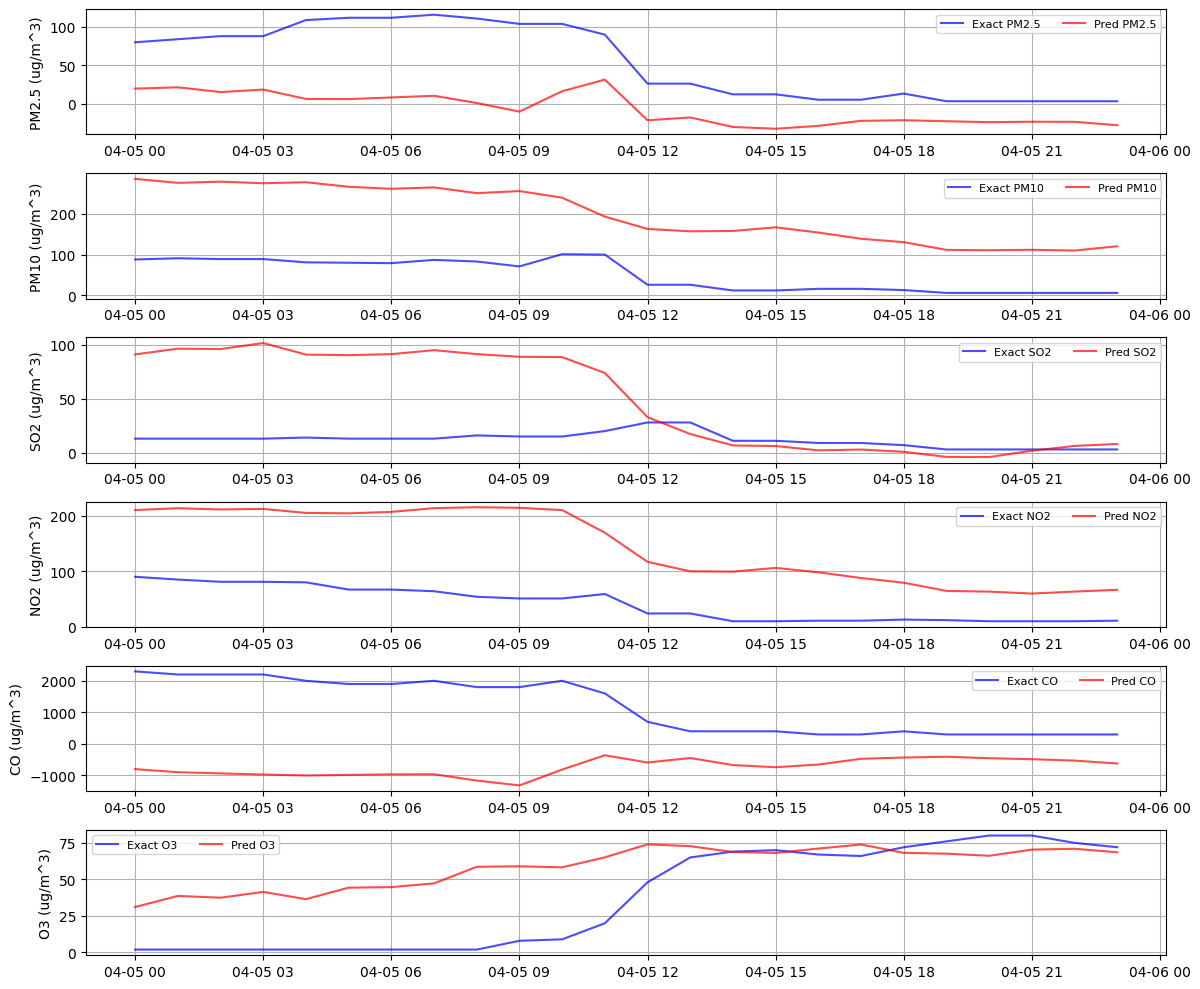

In [68]:
# Predict next 24 hours for all pollutants starting from 2013-03-01
fig, axs = plt.subplots(6, 1, figsize=(12, 10))
for i in range(len(pollutants)):
    y_pred, y_test, R2, RMSE = fit_and_predict_next_n(df, target_col=pollutants[i], start_date="2013-04-05 00:00:00", horizon=24, train_window=720)
    print(f"{pollutants[i]} - R^2: {R2:.3f}, RMSE: {RMSE:.3f}")
    axs[i].plot(y_test.index, y_test.values, label="Exact "+pollutants[i], alpha=0.7, color='blue')
    axs[i].plot(y_pred.index, y_pred.values, label="Pred "+pollutants[i], alpha=0.7, color='red')
    axs[i].set_ylabel(pollutants[i]+ " (ug/m^3)")
    axs[i].legend(ncol=4, fontsize=8)
    axs[i].grid(True)

plt.tight_layout()
plt.show()

R^2: 0.1554506980886301
RMSE: 42.613358206360594


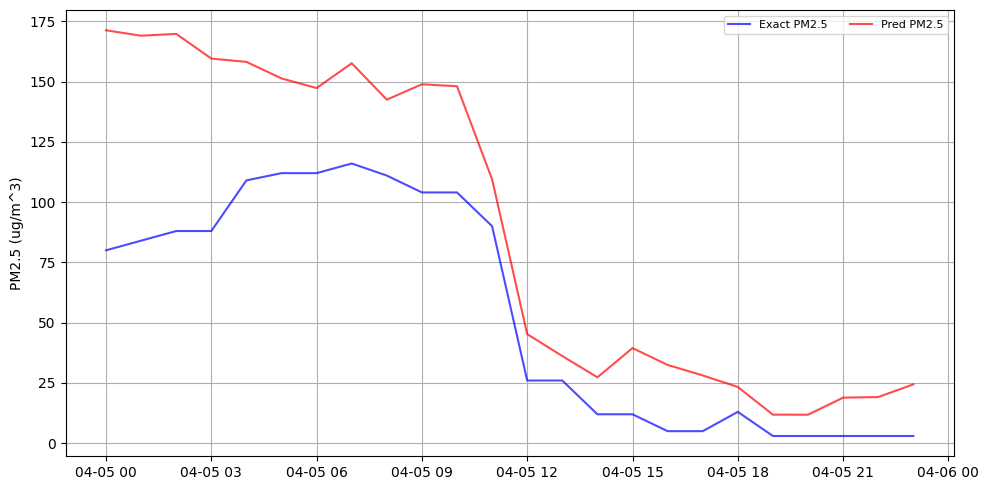

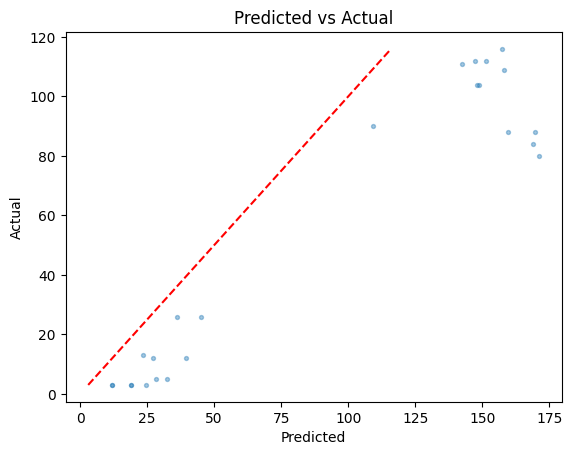

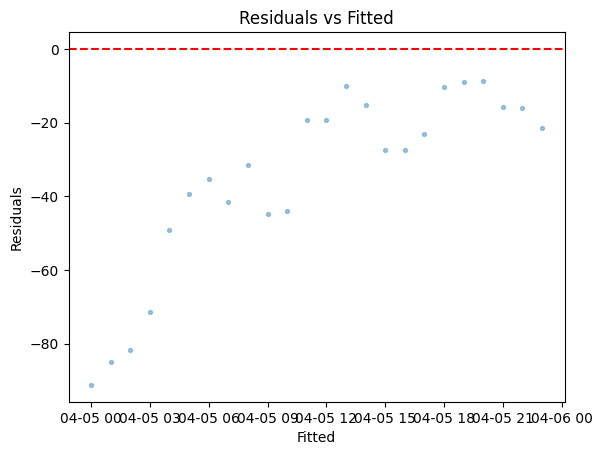

In [69]:
# Detailed analysis for PM2.5 starting from 2013-03-05
y_pred, y_test, R2, RMSE = fit_and_predict_next_n(df, target_col="PM2.5", start_date="2013-04-05 00:00:00", horizon=24, train_window=240)
print("R^2:", R2)
print("RMSE:", RMSE)

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(y_test.index, y_test.values, label="Exact PM2.5", alpha=0.7, color='blue')
ax.plot(y_pred.index, y_pred.values, label="Pred PM2.5", alpha=0.7, color='red')
ax.set_ylabel("PM2.5 (ug/m^3)")
ax.legend(ncol=4, fontsize=8)
ax.grid(True)

plt.tight_layout()
plt.show()

res = y_test - y_pred

# Predicted vs Actual
plt.scatter(y_pred.values, y_test.values, s=8, alpha=0.4)
plt.plot([y_test.values.min(), y_test.values.max()], [y_test.values.min(), y_test.values.max()], "--", color="red")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("Predicted vs Actual")
plt.show()

# Residuals vs Fitted
plt.scatter(res.index, res.values, s=8, alpha=0.4)
plt.axhline(0, linestyle="--", color="red")
plt.xlabel("Fitted"); plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()
